In [1]:
import pandas as pd
import tensorflow_decision_forests as tfdf

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_df.columns = [x.lower() for x in train_df.columns]
test_df.columns = [x.lower() for x in test_df.columns]
train_df = train_df.drop(columns=["name"])
test_df = test_df.drop(columns=["name"])
train_df = train_df[train_df["transported"].notna()]
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passengerid   8693 non-null   object 
 1   homeplanet    8492 non-null   object 
 2   cryosleep     8476 non-null   object 
 3   cabin         8494 non-null   object 
 4   destination   8511 non-null   object 
 5   age           8514 non-null   float64
 6   vip           8490 non-null   object 
 7   roomservice   8512 non-null   float64
 8   foodcourt     8510 non-null   float64
 9   shoppingmall  8485 non-null   float64
 10  spa           8510 non-null   float64
 11  vrdeck        8505 non-null   float64
 12  transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 823.6+ KB
None


,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [2]:
def fill_na(df: pd.DataFrame) -> pd.DataFrame:
    df["homeplanet"].fillna("none", inplace=True)
    df["cryosleep"].fillna(False, inplace=True)
    df["cabin"].fillna("none", inplace=True)
    df["destination"].fillna("none", inplace=True)
    df["age"].fillna(df["age"].mean(), inplace=True)
    df["vip"].fillna(False, inplace=True)
    df["roomservice"].fillna(0, inplace=True)
    df["foodcourt"].fillna(0, inplace=True)
    df["shoppingmall"].fillna(0, inplace=True)
    df["spa"].fillna(0, inplace=True)
    df["vrdeck"].fillna(0, inplace=True)
    return df


train_df = fill_na(train_df)
test_df = fill_na(test_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passengerid   8693 non-null   object 
 1   homeplanet    8693 non-null   object 
 2   cryosleep     8693 non-null   bool   
 3   cabin         8693 non-null   object 
 4   destination   8693 non-null   object 
 5   age           8693 non-null   float64
 6   vip           8693 non-null   bool   
 7   roomservice   8693 non-null   float64
 8   foodcourt     8693 non-null   float64
 9   shoppingmall  8693 non-null   float64
 10  spa           8693 non-null   float64
 11  vrdeck        8693 non-null   float64
 12  transported   8693 non-null   bool   
dtypes: bool(3), float64(6), object(4)
memory usage: 704.7+ KB


In [3]:
# num_cols = [k for k, v in train_df.dtypes.items() if v == "float64"]
# cat_cols = [x for x in train_df.columns if x not in num_cols]
num_cols = ["age", "roomservice", "foodcourt", "shoppingmall", "spa", "vrdeck"]
cat_cols = ["homeplanet", "cryosleep", "cabin", "destination", "vip"]
print(num_cols, cat_cols)
train_df["transported"].value_counts()

['age', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck'] ['homeplanet', 'cryosleep', 'cabin', 'destination', 'vip']


transported
True     4378
False    4315
Name: count, dtype: int64

/Users/robrossmiller/.venv/ml/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


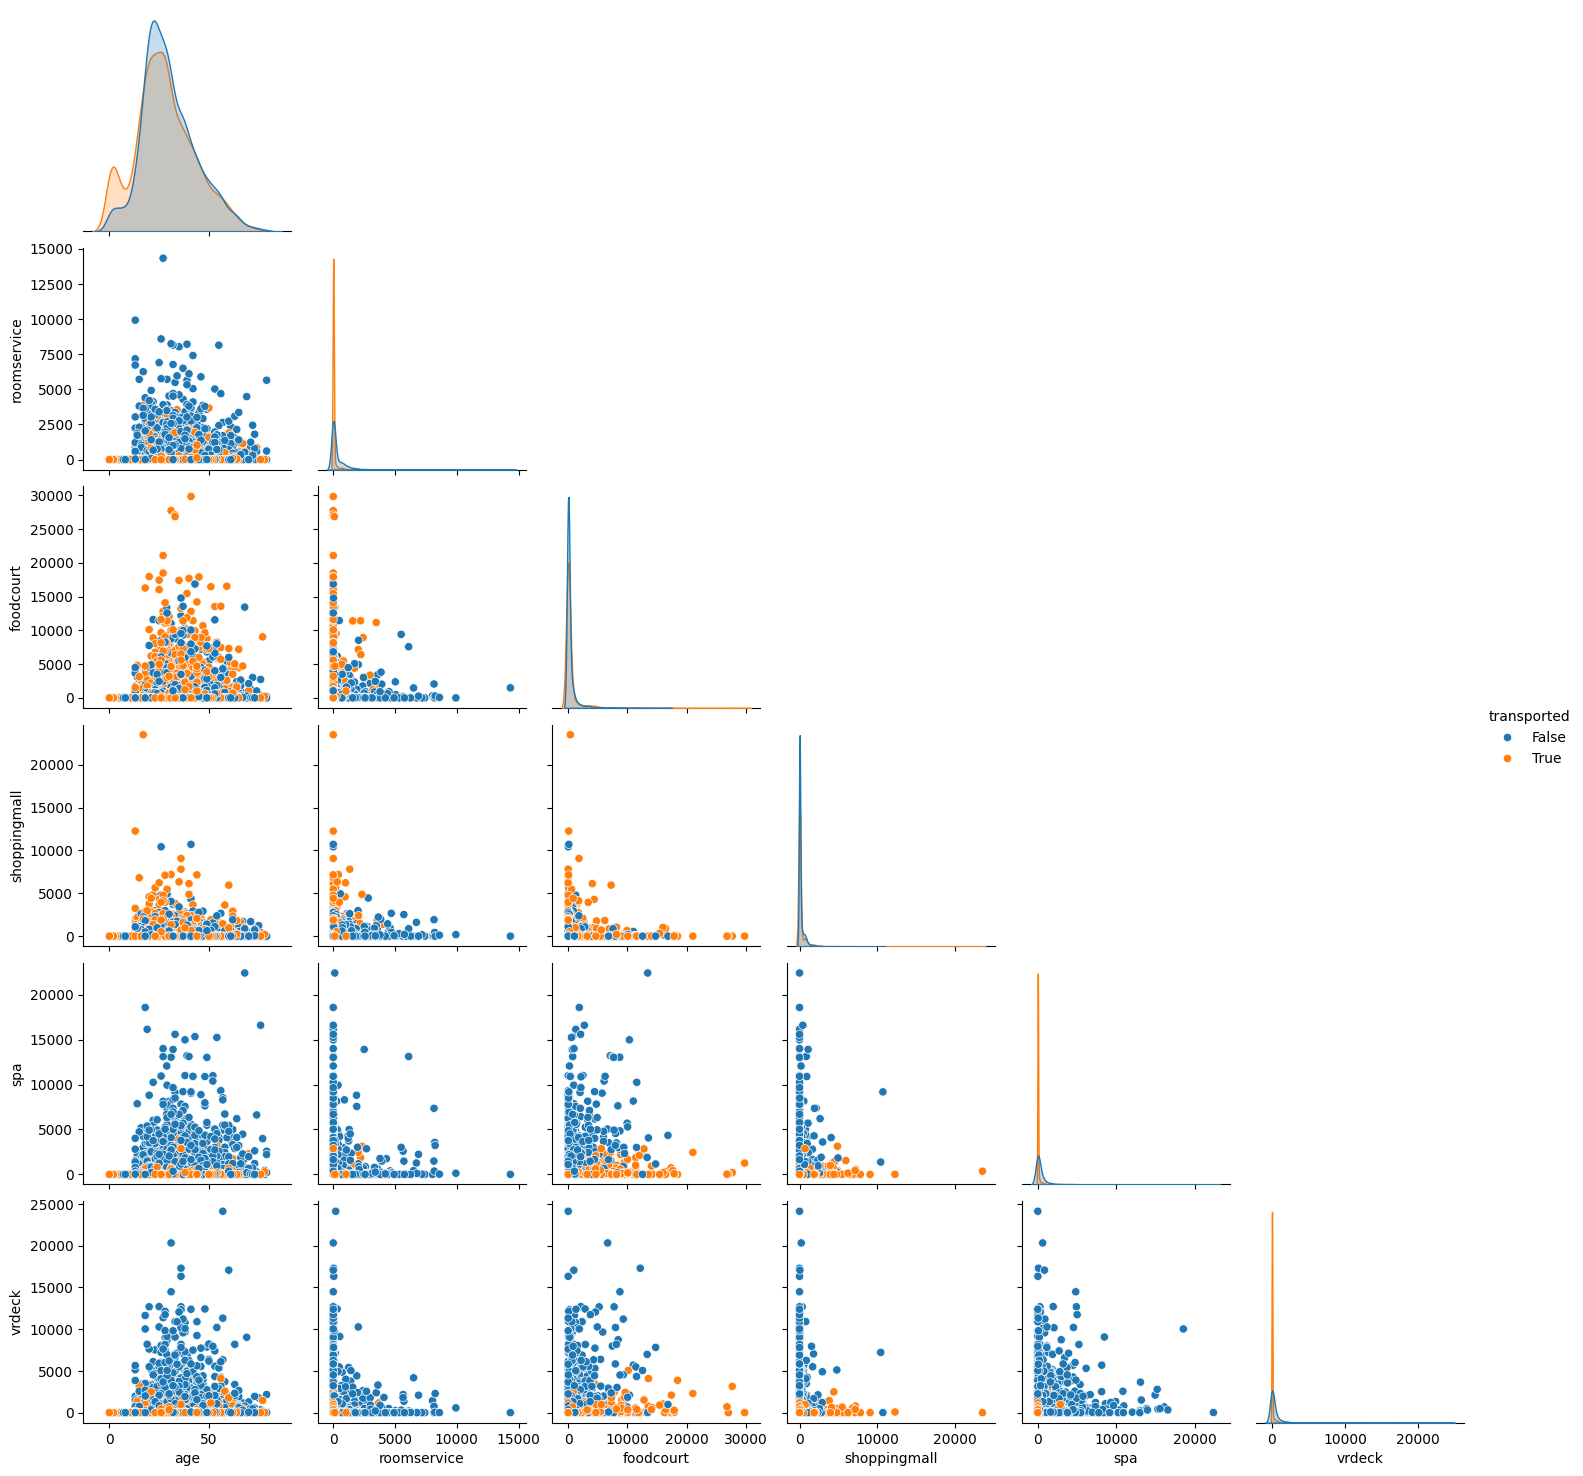

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

t = ["transported"]
t.extend(num_cols)

sns.pairplot(train_df[t], hue="transported", diag_kind="kde", corner=True)

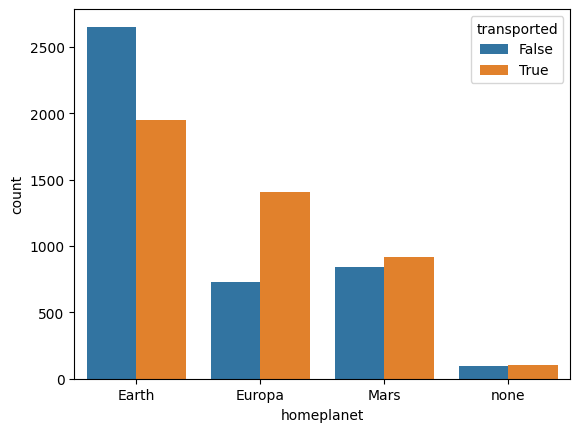

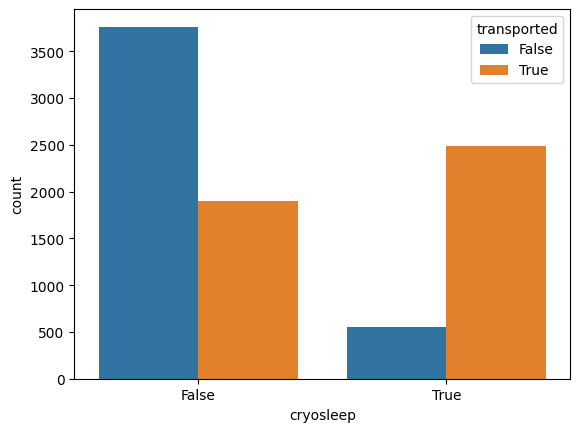

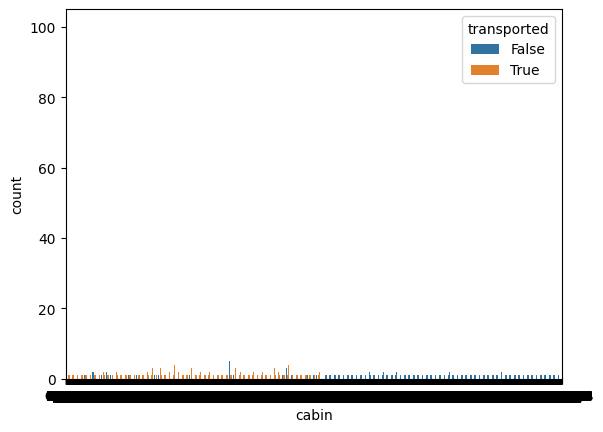

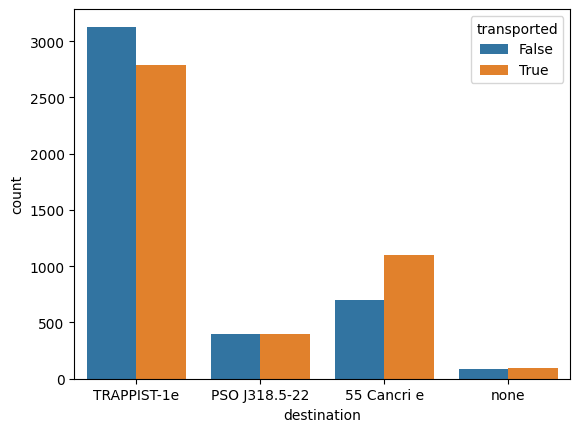

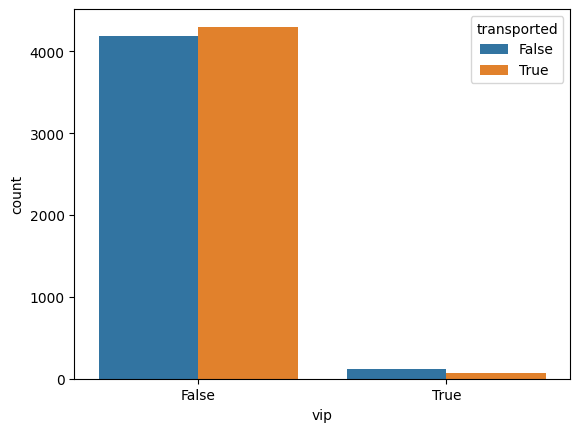

In [5]:
from collections import Counter


for c in cat_cols:
    d = {True: Counter(), False: Counter()}
    for i in train_df[train_df["transported"]][c]:
        d[True][i] += 1
    for i in train_df[~train_df["transported"]][c]:
        d[False][i] += 1

    tmp = {
        c: list(d[True].keys()),
        "count": list(d[True].values()),
        "transported": [True for _ in range(len(d[True].values()))],
    }
    tmp[c].extend(list(d[False].keys()))
    tmp["count"].extend(list(d[False].values()))
    tmp["transported"].extend([False for _ in range(len(d[False].values()))])

    tmp = pd.DataFrame(tmp)
    sns.barplot(tmp, x=c, y="count", hue="transported")
    plt.show()

In [6]:
# categorical vars
from sklearn.preprocessing import OrdinalEncoder


def encode(df: pd.DataFrame):
    oe = OrdinalEncoder()
    for c in ["cryosleep", "vip"]:
        print(df[c].to_numpy().reshape(1, -1))
        df[c] = oe.fit_transform(df[c].to_numpy().reshape(1, -1))[0]

    return df


train_df = encode(train_df)
test_df = encode(test_df)
test_df.dtypes

[[False False False ... False False False]]
[[False False  True ... False False False]]
[[ True False  True ...  True False  True]]
[[False False False ... False False False]]


passengerid      object
homeplanet       object
cryosleep       float64
cabin            object
destination      object
age             float64
vip             float64
roomservice     float64
foodcourt       float64
shoppingmall    float64
spa             float64
vrdeck          float64
dtype: object

In [7]:
# Convert the dataset into a TensorFlow dataset.
tdf = train_df.sample(int(train_df.shape[0] * 0.8))
edf = train_df[~train_df["passengerid"].isin(tdf["passengerid"])]
assert tdf.shape[0] + edf.shape[0] == train_df.shape[0]
tdf = tdf.drop(columns="passengerid")
edf = edf.drop(columns="passengerid")
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(tdf, label="transported")
eval_ds = tfdf.keras.pd_dataframe_to_tf_dataset(edf, label="transported")

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df.drop(columns="passengerid"))

In [8]:
edf.head()

,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported
1,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,True
2,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,0.0,43.0,3576.0,0.0,6715.0,49.0,False
5,Earth,0.0,F/0/P,PSO J318.5-22,44.0,0.0,0.0,483.0,0.0,291.0,0.0,True
9,Europa,0.0,B/1/P,55 Cancri e,14.0,0.0,0.0,0.0,0.0,0.0,0.0,True
22,Earth,0.0,E/0/S,55 Cancri e,49.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [9]:
# Train a Random Forest model.
from sklearn.metrics import accuracy_score


models = {}
for x in tfdf.keras.get_all_models():
    if "Distributed" in x.__name__:
        continue
    print(x.__name__)
    model = x()
    # model = tfdf.keras.RandomForestModel()
    # model = tfdf.keras.GradientBoostedTreesModel()
    # model = tfdf.keras.CartModel()
    model.fit(train_ds, verbose=0)

    # Summary of the model structure.
    # model.summary()

    preds = model.predict(eval_ds, verbose=0)
    d = {"PassengerId": [], "Transported": []}
    for p, i in zip(preds, test_df["passengerid"]):
        d["PassengerId"].append(i)
        d["Transported"].append(p[0] > 0.5)

    models[accuracy_score(edf["transported"].tolist(), d["Transported"])] = model

# pick the winner
max_score = max(models.keys())
model = models[max_score]
model.name

RandomForestModel
Use /var/folders/ph/4tyn5b_j1f9dgxvg9f47pd3h0000gn/T/tmp6kq39zpb as temporary training directory


[INFO 23-10-23 23:27:20.5357 EDT kernel.cc:1233] Loading model from path /var/folders/ph/4tyn5b_j1f9dgxvg9f47pd3h0000gn/T/tmp6kq39zpb/model/ with prefix 08eca27076464183
[INFO 23-10-23 23:27:20.7964 EDT decision_forest.cc:660] Model loaded with 300 root(s), 222804 node(s), and 9 input feature(s).
[INFO 23-10-23 23:27:20.7964 EDT abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 23-10-23 23:27:20.7965 EDT kernel.cc:1061] Use fast generic engine


GradientBoostedTreesModel
Use /var/folders/ph/4tyn5b_j1f9dgxvg9f47pd3h0000gn/T/tmp_nvf369m as temporary training directory


[WARNING 23-10-23 23:27:21.2291 EDT gradient_boosted_trees.cc:1830] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-23 23:27:21.2294 EDT gradient_boosted_trees.cc:1841] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-23 23:27:21.2294 EDT gradient_boosted_trees.cc:1855] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


CartModel
Use /var/folders/ph/4tyn5b_j1f9dgxvg9f47pd3h0000gn/T/tmpmae_sqls as temporary training directory


[INFO 23-10-23 23:27:21.6572 EDT kernel.cc:1233] Loading model from path /var/folders/ph/4tyn5b_j1f9dgxvg9f47pd3h0000gn/T/tmp_nvf369m/model/ with prefix b8932f95815c4794
[INFO 23-10-23 23:27:21.6613 EDT kernel.cc:1061] Use fast generic engine
[INFO 23-10-23 23:27:21.8528 EDT kernel.cc:1233] Loading model from path /var/folders/ph/4tyn5b_j1f9dgxvg9f47pd3h0000gn/T/tmpmae_sqls/model/ with prefix 260d9981f3dc4d81
[INFO 23-10-23 23:27:21.8531 EDT decision_forest.cc:660] Model loaded with 1 root(s), 93 node(s), and 9 input feature(s).
[INFO 23-10-23 23:27:21.8531 EDT kernel.cc:1061] Use fast generic engine


'random_forest_model'

In [10]:
# Evaluate the model.
preds = model.predict(test_ds)
d = {"PassengerId": [], "Transported": []}
for p, i in zip(preds, test_df["passengerid"]):
    d["PassengerId"].append(i)
    d["Transported"].append(p[0] > 0.5)

pd.DataFrame(d).to_csv("data/preds.csv", index=False)

5/5 [==============================] - 0s 25ms/step
